<a href="https://colab.research.google.com/github/salmanarif86/MLAI/blob/master/Jewelry_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns 

from sklearn.metrics import silhouette_score, silhouette_samples
import sklearn.metrics
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
%matplotlib inline

import pandas_profiling
import plotly.express as px
import mpl_toolkits.mplot3d.axes3d as p3
from matplotlib import animation

import itertools

import scipy

from yellowbrick.cluster import SilhouetteVisualizer, InterclusterDistance, KElbowVisualizer

from kmodes.kmodes import KModes

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# This will ensure that matplotlib figures don't get cut off when saving with savefig()
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

Loading the data as a pandas dataframe

In [0]:
df = pd.read_csv('/content/jewelry_customers (2).csv')

We have gathered some interesting insights into the data 
- There are a total of 505 instances
- There are no missing values
- The mean income is 75K and the range is (35K - 142K) with a Standard deviation of 36K

In [208]:
df.shape
df.info()
df.describe().transpose()


(505, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
Age              505 non-null int64
Income           505 non-null int64
SpendingScore    505 non-null float64
Savings          505 non-null float64
dtypes: float64(2), int64(2)
memory usage: 15.9 KB


,count,mean,std,min,25%,50%,75%,max
Age,505.0,59.019802,24.140043,17.0,34.000000,59.000000,85.000000,97.0
Income,505.0,75513.291089,35992.922184,12000.0,34529.000000,75078.000000,107100.000000,142000.0
SpendingScore,505.0,0.505083,0.259634,0.0,0.304792,0.368215,0.768279,1.0
Savings,505.0,11862.455867,4949.229253,0.0,6828.709702,14209.932802,16047.268331,20000.0


Again we can gather some more interesting insights

- The distribution of Age is a trimodal distribution
- The distribution of Income is also a trimodal distribution
- Pearson correlation that measures the strength of a linear realationship between two variables shows a high degree of negative correlation between Age and Income (Surprisng as I would have thought that income increases with age)
- Spearman which measures the strength and direction of monotonic behaviour also shows a negative correlation between Age and Income (Surprisng as I would have thought that income increases with age)
- Age and Saving are positively correlated in pearson and spearman which does make sense. 
- Saving and Spending score is ngeatively correlated in both pearson and spearman. This means that people who save less tend to spend more which makes also an interesting observation

In [209]:
pandas_profiling.ProfileReport(df)

/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning:

The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.



Number of variables,4
Number of observations,505
Total Missing (%),0.0%
Total size in memory,15.9 KiB
Average record size in memory,32.3 B
Numeric,4
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


Here we see clear groups of indiviuals 

- There are 4 distinct group based on Age and Income
- There are about 4-5 distinct group based on Age and Spending Score
- There are about 4 distinct group based on Age and Savings
- There are 2 distinct groups based on Saving and Spending score and again we see that people who save less tend to spend more and have a high spending score

/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)


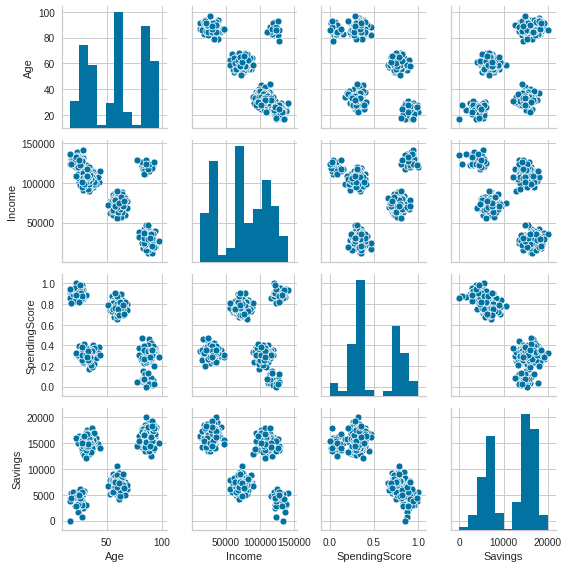

In [8]:
cols = ['Age', 'Income', 'SpendingScore', 'Savings']
sns.pairplot(df[cols], size=2.0)

In [0]:
scaler = MinMaxScaler()
features = ['Income', 'SpendingScore','Age','Savings']
df[features] = scaler.fit_transform(df[features])

In [211]:
df.shape
df.info()
df.describe().transpose()
df.head(10)
df.tail()

(505, 4)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 4 columns):
Age              505 non-null float64
Income           505 non-null float64
SpendingScore    505 non-null float64
Savings          505 non-null float64
dtypes: float64(4)
memory usage: 15.9 KB


,count,mean,std,min,25%,50%,75%,max
Age,505.0,0.525248,0.301751,0.0,0.212500,0.525000,0.850000,1.0
Income,505.0,0.488564,0.276869,0.0,0.173300,0.485215,0.731538,1.0
SpendingScore,505.0,0.505083,0.259634,0.0,0.304792,0.368215,0.768279,1.0
Savings,505.0,0.593123,0.247461,0.0,0.341435,0.710497,0.802363,1.0


,Age,Income,SpendingScore,Savings
0,0.5125,0.505915,0.791329,0.327991
1,0.5250,0.536915,0.791082,0.270883
2,0.5625,0.482700,0.702657,0.462950
3,0.5250,0.479792,0.765680,0.367317
4,0.8750,0.044308,0.348778,0.843475
5,0.1500,0.919831,0.847034,0.176776
6,0.4625,0.496154,0.785198,0.343944
7,0.8750,0.235323,0.355290,0.904314
8,0.8250,0.172185,0.324719,0.739169
9,0.8375,0.120715,0.367063,0.893978


,Age,Income,SpendingScore,Savings
500,0.1375,0.686200,0.387441,0.746839
501,0.9500,0.061031,0.203140,0.898485
502,0.9125,0.179208,0.355149,0.804570
503,0.9250,0.066777,0.354679,0.920054
504,0.9000,0.140515,0.289310,0.719318


**k-Means Clustering**
In my experience, this is by far the most frequently used algorithm for clustering data. k-Means starts by choosing k random centers which you can set yourself. Then, all data points are assigned to the closest center based on their Euclidean distance. Next, new centers are calculated and the data points are updated. This process continuous until clusters do not change between iterations.

We can use k-means++ to improve the initialization of the centers. It starts with an initial center and makes sure that all subsequent centers are sufficiently far away. This optimizes the selection and creation of centers.

One thing to note, since k-Means typically uses Euclidean distance to calculate the distances it does not work well with high dimensional data sets due to the curse of dimensionality. This curse, in part, states that Euclidean distances at high dimensionality have very little meaning since they are often very close together.

The dataset we have only has 4 features and is not high-dimensional so therefore we will go along and use k-means

In this partcular problem we dont have access to ground truth and as a result we can't use any accuracy metrics. We will use internal validation metrics

The idea is that we should get clusters that have low intra-cluster distance and high inter-cluster distance

**Intertia**
The sum of the square distance from each instance to the cluster centroid. This is a measure of compactness

* Lower WCSS (within - cluster sum of squares) = more compact clusters 
* higer WCSS (within - cluster sum of squares) = less compact clusters 

If we draw an elbow plot you can see that the intertia or within-cluster distance continues to decrease until 5 clusters after which there is no change in the compactness


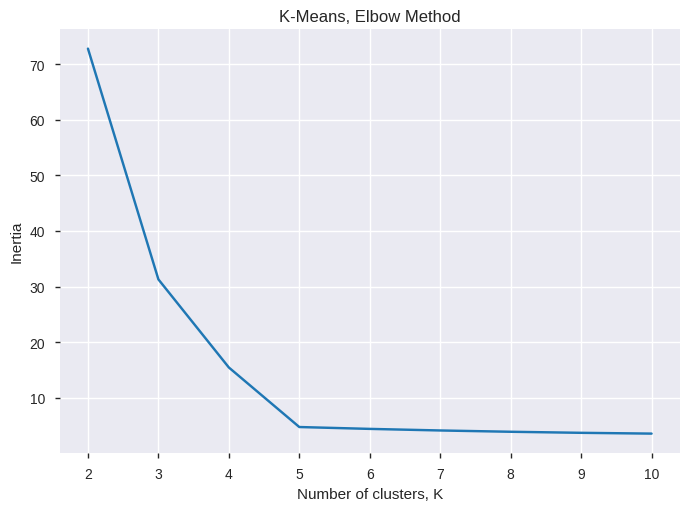

In [212]:
inertias = {}
silhouettes = {}
for k in range(2, 11):
    kmeans = KMeans(init='k-means++', n_init=10, n_clusters=k, max_iter=1000, random_state=42).fit(df)
    inertias[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    silhouettes[k] = silhouette_score(df, kmeans.labels_, metric='euclidean')
    

plt.figure();
plt.grid(True);
plt.plot(list(inertias.keys()), list(inertias.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Inertia");



While we are measuring the within cluster sum of square distance we also need to be mindful of the inter cluster distance. 

**Silhouette Coefficient**
* Measures distance between clusters
* Calculates the distance between each instance and the center of the nearest neighbouring cluster


    1. 1: isntance is far away from the closest neighbouring cluster   
    2. < 1: instance is close to the closest neighbouring cluster
    3. 0: instance is on or very close to the decision boundry

Looking at the elbow method below we can see that the inter-cluster distance continues to increase until cluster 5 after which we start to see a drop.

Both interia and Silhouette distance point us towards 5 clusters in our dataset



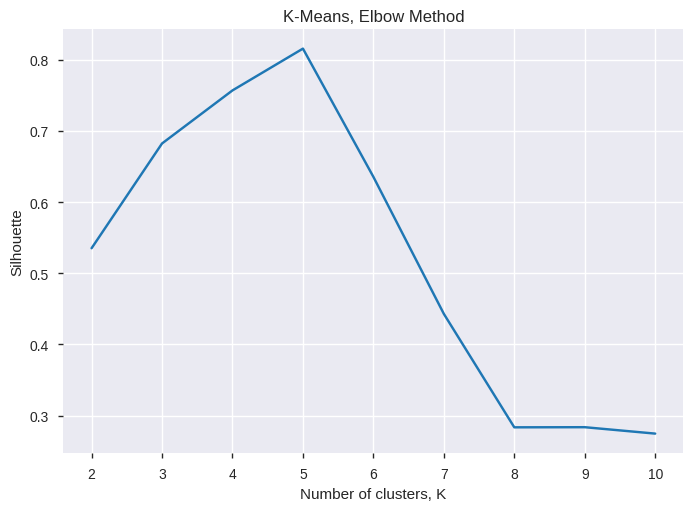

In [213]:
plt.figure();
plt.grid(True);
plt.plot(list(silhouettes.keys()), list(silhouettes.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.ylabel("Silhouette");

Again visual demonstration shows that they are no bad clusters

SilhouetteVisualizer(ax=<matplotlib.axes._subplots.AxesSubplot object at 0x7fbe961849e8>,
                     model=None)

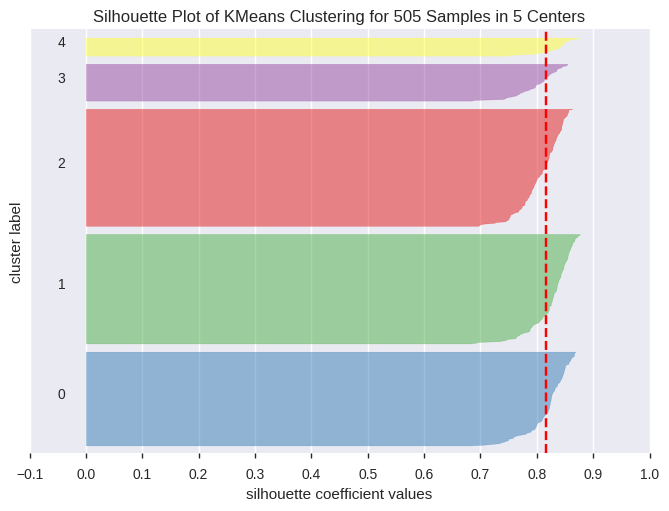

In [214]:
visualizer = SilhouetteVisualizer(k_means)
visualizer.fit(df)
visualizer.poof()
fig = visualizer.ax.get_figure()

In [215]:
k_means = KMeans(init='k-means++', n_clusters=5, n_init=10, random_state=42)
k_means.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [0]:
df_kmeans = pd.concat([df,pd.DataFrame(k_means.labels_)],axis=1)
df_kmeans.rename(columns ={0: 'Kmeans'},inplace=True)

**DBSCAN**

I also want to use DBSCAN to see if there are any dissimilarity between the clusters created by KMeans as oppose to DBSCAN. I would also like to verify my KMeans value of K = 5 with DBSCAN. DBSCAN does not use K as an input but spits out the number of clusters as an output based on the density of the data points 

One of the main disadvantages of KMeans is because of the nature of the Euclidean distances,it is not a suitable algorithm when dealing with clusters that adopt non-spherical shapes.

Whereas DBSCAN there is high flexibility in the shapes and sizes that the clusters may adopt. It is very useful to identify and deal with noise data and outliers.

In [0]:
min_samples = df.shape[1] + 1
dbscan = DBSCAN(eps =3.5, min_samples=min_samples).fit(df)

In [0]:
def prepare_pca(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = PCA(n_components=n_components).fit_transform(data)
    matrix = pd.DataFrame(matrix)
    matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    matrix['labels'] = kmeans_labels
    return matrix
    print(matrix)

Using dimensionality reduction PCA to reduce the complexity to a 2-dimensional surface and then plotting this on graph for both Kmeans and DBSCAN

KMeans cluster look very spherical and therefore Kmeans should do a very good job. We also have less dimensions (just 4) in the problem do Kmeans would not suffer from the curse of dimensionality.

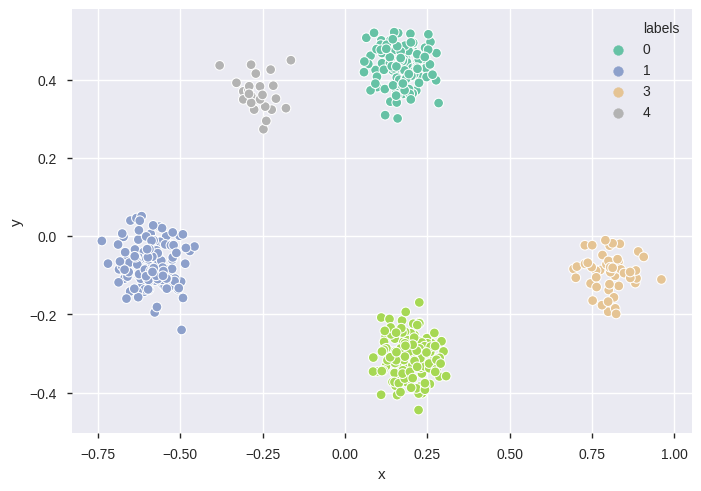

In [261]:
pca_df = prepare_pca(2, df, k_means.labels_)
sns.scatterplot(x=pca_df['x'], y=pca_df['y'], hue=pca_df.labels, 
               palette="Set2")

DBSCAN almost give the same clusters as our benchmark KMeans algorithm

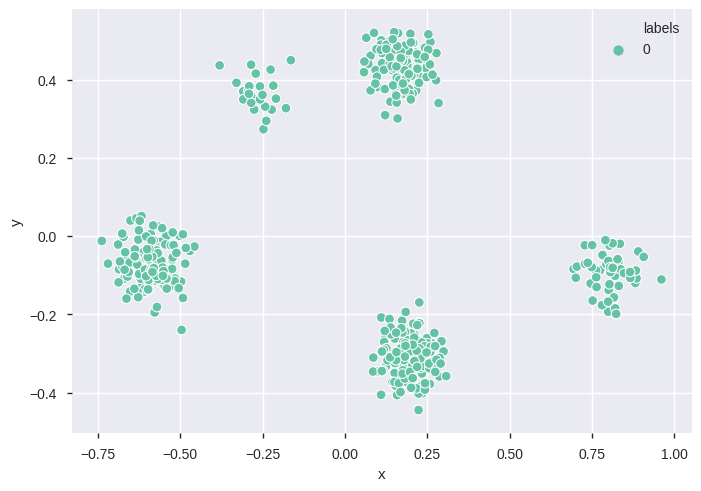

In [264]:
pca_dbscan = prepare_pca(2, df, dbscan.labels_)
sns.scatterplot(x=pca_dbscan['x'], y=pca_dbscan['y'], hue=pca_dbscan.labels, 
               palette="Set2")

In [0]:
def plot_3d(df, name='labels'):
    iris = px.data.iris()
    fig = px.scatter_3d(df, x='x', y='y', z='z',
                  color=name, opacity=0.5)
    fig.update_traces(marker=dict(size=3))
    fig.show()

3D plots of the algorithms show us the same results. Henece we can quite comfortably conclude that our benchmark KMeans is sufficient and shows very consistent results when compared to DBSCAN. Also our value of K is justfied as DBSCAN automatically asigns clusters based on the density of the data points

In [220]:
plot_3d(pca_df)

In [258]:
plot_3d(pca_dbscan)

In [0]:
def prepare_tsne(n_components, data, kmeans_labels):
    names = ['x', 'y', 'z']
    matrix = TSNE(n_components=n_components).fit_transform(data)
    df_matrix = pd.DataFrame(matrix)
    df_matrix.rename({i:names[i] for i in range(n_components)}, axis=1, inplace=True)
    df_matrix['labels'] = kmeans_labels
    return df_matrix

In [0]:
tsne_3d_df = prepare_tsne(3, df, k_means.labels_)

In [223]:
plot_3d(tsne_3d_df)

In [259]:
tsne_3d_dbscan = prepare_tsne(3, df, dbscan.labels_)
plot_3d(tsne_3d_dbscan)

**Evaluation**
One assumption of variable importance in cluster tasks is that if the average value of a variable ordered by clusters differs significantly among each other, that variable is likely important in creating the clusters.

I simply calculate the variance of means between clusters within each variable 

Then, calculate the standard deviation between those values for each variable. Variables with high standard deviation indicate that there are large diffrences between clusters and that the variable might be important


In [240]:
df_mean = df_kmeans.groupby('Kmeans').mean().reset_index()
df_mean

,Kmeans,Age,Income,SpendingScore,Savings
0,0,0.197222,0.717429,0.309926,0.748139
1,1,0.884694,0.122047,0.328800,0.832963
2,2,0.536943,0.464985,0.771518,0.344499
3,3,0.089750,0.892532,0.896892,0.204376
4,4,0.862500,0.830339,0.068378,0.740434


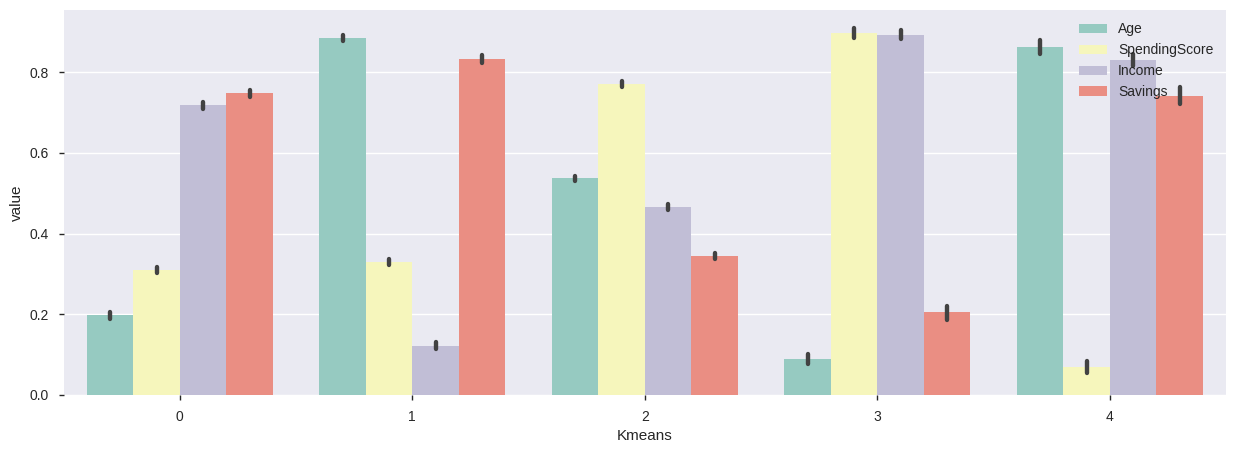

In [230]:
results = pd.DataFrame(columns=['Variable', 'Std'])
for column in df_mean.columns[1:]:
    results.loc[len(results), :] = [column, np.std(df_mean[column])]
selected_columns = list(results.sort_values('Std', ascending=False).Variable.values) + ['Kmeans']
# Plot data
tidy = df_kmeans[selected_columns].melt(id_vars='Kmeans')
fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(x='Kmeans', y='value', hue='variable', data=tidy, palette='Set3')
plt.legend(loc='upper right')


**Labels for each clusters**

Cluster 0 - Young Adults who have high earning and high savings and usually dont spend alot - Careful Spenders

Cluster 1 - older people whose income is not quite alot but have high savings and dont spend quite as much - Careful Spenders

Cluster 2 - Young Adults who spend alot and have avearge income and average saving but tend to spend alot

Cluster 3 - Yound adults with very high income and very high spending power who dont tend to save alot

Cluster 4 - older people with both high income and high savings and spend the least out of all our customers

I am quite confident with the results we have been able to achieve by runing clustering algorithms. First we ran a benchmark KMeans clustering to see how the results look like. We based our value of K on intertia and Silhouette distances which are intra and inter cluster distances. Since its a distance based clustering algorithm its important to standradize all the data. 

To compare our results we ran Density-Based Spatial Clustering. The idea was that we should compare the results from both the algorithms and see any dissimalirties. DBSCAN as oppose to KMeans outputs the #no. of clusters as its result. DBSCAN showed us the same number of clusters as KMeans that we picked manually by looking at inertia and silhouette graphs

In the end we visualized the clusters using both PCA and t-SNE on a 2d and 3d surface and found out that the custers are fairly sphericals and with very few outliers

Cluster defination was easy as we saw quite stark difference in the variance of means between clusters within each variable